## Why $Q$-learning isn't always enough

In the [previous post](dqn) we took a deep dive into deep $Q$-learning, the technique that [scored human-level performance](https://www.nature.com/articles/nature14236) from raw pixels on Atari games like Breakout. This technique was developed to allow $Q$-learning on continuous observation spaces $\mathcal{S}$. The fundamental limitation of deep $Q$-learning, however, is that it only work on MDPs with discrete action spaces $\mathcal{A}$.

$Q$-learning works by learning to estimate the values of $Q^\pi(s_t, a_t)$ for every state-action pair $(s_t, a_t)$. Then, given a state $s_t$, it uses a greedy policy that just chooses the action with the highest $Q$ value:

$$
\pi(a_t \mid s_t) = 
\begin{cases}
1 & a_t = \arg \max_{a_t} Q^\pi(s_t, a_t) \\
0 & \text{otherwise}
\end{cases}
$$

This policy is deterministic (i.e., always chooses the same action). This can be a problem when we want our agent to explore, since exploration requires trying out different actions. We solved this problem somewhat using $\epsilon$-greedy policies and epsilon decay, but what if we wanted our policy to be stochastic? In their most general definition, policies are just probability distributions over actions, and we sample actions from those probability distributions. More narrow distributions are more likely to choose the same actions (with policies like those used in $Q$-learning as an extreme example), and more broad distributions are more likely to choose different actions (with a random agent as an extreme example).

In order to use continuous action spaces and have stochastic policies, we have to model the policy $\pi$ directly. We can parametrize our policy using some parameters $\theta$ to produce a distribution over actions:

$$
\pi_\theta(a_t \mid s_t) = p(a_t \mid s_t, \theta)
$$



Like in $Q$-learning (and all of reinforcement learning, really) our goal is to find a policy $\pi$ that maximizes the expected cumulative reward. Let's call the quantity that we want to maximize the **objective** $J$. The objective value for a certain policy with parameters $\theta$ is denoted $J(\theta)$. 

$$
J(\theta) = \mathbb{E}_\tau \left[ G_0 \mid s_0 \right] = \sum_\tau p(\tau) G_0
$$

where $G_0$ is the discounted return from the beginning state of the trajectory $\tau$.

We want to maximize this objective via **gradient ascent** on $J(\theta)$ with respect to policy parameters $\theta$:

$$
\theta \gets \theta + \alpha \nabla_\theta J(\theta)
$$

We can use the **log-derivative** trick to express the gradient as

$$
\nabla f(x) = f(x) \log \nabla f(x)
$$

If we apply the log-derivative trick to the gradient of the objective, we get

$$
\nabla_\theta J(\theta) = \sum_\tau p(\tau) \nabla_\theta \log p(\tau) G_0
$$

To compute the probability of a trajectory.

$$
p(\tau) = p(s_0) \prod_{t=0}^{T} p(s_{t+1} \mid s_t, a_t) \pi_\theta (a_t \mid s_t)
$$

This is similar to the equation derived in the [previous post]({% post_url 2020-05-26-q-learning %}) on $Q$-learning, except that we must also include the fact that actions are selected probabilistically according to the policy $\pi_\theta$. 

The log-probability of a trajectory $\tau$ is then just

$$
\begin{align}
\log p(\tau) &= \log \left(p(s_0) \prod_{t=0}^{T} p(s_{t+1} \mid s_t, a_t) \pi_\theta (a_t \mid s_t)\right) \\
&= \log p(s_0) + \sum_{t=0}^T \Bigg( \log p(s_{t+1} \mid s_t, a_t) + \log \pi_\theta (a_t \mid s_t) \Bigg)
\end{align}
$$

Let's take a closer look at the gradient of $\log p(\tau)$ with respect to $\theta$:

$$
\nabla_\theta \log p(\tau) = \cancel{\log p(s_0)} + \sum_{t=0}^T \Bigg( \cancel{\log p(s_{t+1} \mid s_t, a_t)} + \log \pi_\theta (a_t \mid s_t) \Bigg)
$$

The distribution over initial states $p(s_0)$ is independent of $\theta$, as are the state transition dynamics. This leaves us with

$$
\nabla_\theta \log p(\tau) = \sum_{t=0}^T \log \pi_\theta (a_t \mid s_t)
$$

Substituting this back into our expression for the policy gradient, we get

$$
\nabla_\theta J(\theta) = \sum_\tau  p(\tau) \Bigg( \sum_{t=0}^T \log \pi_\theta (a_t \mid s_t) \Bigg) G_0
$$

But this is exactly the form of an expectation over $\tau$!

$$
\nabla_\theta J(\theta) = \mathbb{E}_\tau \left[ \sum_{t=0}^T \log \pi_\theta (a_t \mid s_t) G_0 \right]
$$

For each action $a_t$, we essentially make a gradient step that changes $\log \pi_\theta (a_t \mid s_t)$ based on the scale of $G_0$. If we have a bad trajectory and $G_0 < 0$ then we decrease the log probability of each action along the trajectory, and if we have a good trajectory and $G_0 > 0$ then we increase the log probability of each action along the trajectory.

This expression is known as the **policy gradient**, and is sufficient to do basic reinforcement learning. However, if we expand $G_0$, we see that

$$
\nabla_\theta J(\theta) = \mathbb{E}_\tau \left[ \sum_{t=0}^T \log \pi_\theta (a_t \mid s_t) \sum_{t=0}^T \gamma^t r_t \right]
$$

This means that we scale each action according to the rewards seen at every time step. But why should this be the case? Why would I change the probability of an action at time $t$ according to the reward seen at some earlier time $t' < t$? 

It turns out that we can actually drop terms where that is the case:

$$
\nabla_\theta J(\theta) = \mathbb{E}_\tau \left[ \sum_{t=0}^T \log \pi_\theta (a_t \mid s_t) \sum_{k=t}^T \gamma^k r_k \right]
$$

(see a proof [here](https://spinningup.openai.com/en/latest/spinningup/extra_pg_proof1.html)).

The right hand term is

$$
\begin{align}
\sum_{k=t}^T \gamma^k r_k &= \gamma^t \sum_{k=t}^T \gamma^{k-t} r_t \\
&= \gamma^t G_t
\end{align}
$$

which is just the discounted return $G_t$ but scaled by the discount factor $\gamma^t$. In practice, we drop the $\gamma^t$ term, giving us

$$
\nabla_\theta J(\theta) = \mathbb{E}_\tau \left[ \sum_{t=0}^T \log \pi_\theta (a_t \mid s_t) G_t \right]
$$

At each time step $t$ in the sum we have access to the $s_t$ and $a_t$. As a result, we can also write

$$
\nabla_\theta J(\theta) = \mathbb{E}_\tau \left[ \sum_{t=0}^T \log \pi_\theta (a_t \mid s_t) V^{\pi_\theta}(s_t) \right]
$$

since 

$$
V^{\pi_\theta}(s_t) = \mathbb{E}_\tau \left[ G_t \mid s_t \right]
$$

Similarly, we can also write

$$
\nabla_\theta J(\theta) = \mathbb{E}_\tau \left[ \sum_{t=0}^T \log \pi_\theta (a_t \mid s_t) Q^{\pi_\theta}(s_t, a_t) \right]
$$

since

$$
Q^{\pi_\theta}(s_t, a_t) = \mathbb{E}_\tau \left[ G_t \mid s_t, a_t \right]
$$

REINFORCE directly applies the policy gradient theorem by sampling the expectation in the gradient and using it as an estimate for the gradient. We run a **rollout** of the policy $\pi_\theta$ in our environment for $T$ time steps, storing the states, actions, rewards, and done flags at each time step $t$. Then, we compute an empirical estimate for the gradient:

$$
\hat{g} = \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t \mid s_t) G_t
$$

where we use $\hat{g}$ as a short hand for "estimate of the gradient".

This can be easily implemented using an autograd library like PyTorch by defining a loss function:

$$
L^{\text{PG}} = \sum_{t=0}^T \log \pi_\theta(a_t \mid s_t) G_t
$$

then the gradient is just

$$
\begin{align}
\nabla_\theta L^{\text{PG}} &= \nabla_\theta \sum_{t=0}^T \log \pi_\theta(a_t \mid s_t) G_t \\
&= \sum_{t=0}^T \nabla_\theta  \log \pi_\theta(a_t \mid s_t) G_t
\end{align}
$$

which is the gradient we want. We can use this gradient for gradient *ascent* by flipping the sign, and doing gradient *descent*. This is how we will be implementing REINFORCE.

This is a good time to bring up the difference between **on-policy** learning and **off-policy** learning.

**On-policy** learning requires that data used for training a policy $\pi$ is actually collected *by that policy*. Policy gradient-based algorithms, such as REINFORCE, are usually on-policy. This is evident in the form of the policy gradient theorem, where the expectation is taken over trajectories $\tau$, whose distribution depends directly on the policy $\pi$.

**Off-policy** learning does not require that data used for training a policy $\pi$ be collected by that policy. For example, $Q$-learning (and deep $Q$-learning) are off-policy algorithms. $Q$-learning only requires data of the form $s_t, a_t, r_t, s_{t+1}$ to learn the $Q$-function. This data could easily be collected by a random policy.

When using an on-policy algorithm, if we collect training data and then use that data to update our policy's parameters $\theta$, we cannot re-use that data for further training since the updated policy no longer matches the policy that collected the data. This is the downside of on-policy algorithms.



To get a less variable estimate of the gradient $\hat{g}$, we can run multiple rollouts in parallel and compute the average gradient over each rollout. This stabilizes training and allows us to increase our learning rate since we can be more confident in out gradient estimate.

Below we provide the same implementation for a vectorized environment that we used in the [previous post](dqn) (with a minor change since we will be allowing non-discrete actions this time):

In [1]:
import copy
import numpy as np
import gym

class VectorizedEnvWrapper(gym.Wrapper):
    def __init__(self, env, num_envs=1):
        '''
        env (gym.Env): to make copies of
        num_envs (int): number of copies
        '''
        super().__init__(env)
        self.num_envs = num_envs
        self.envs = [copy.deepcopy(env) for n in range(num_envs)]
    
    def reset(self):
        '''
        Return and reset each environment
        '''
        return np.asarray([env.reset() for env in self.envs])
    
    def step(self, actions):
        '''
        Take a step in the environment and return the result.
        actions (torch.tensor)
        '''
        next_states, rewards, dones = [], [], []
        for env, action in zip(self.envs, actions):
            next_state, reward, done, _ = env.step(action.item())
            if done:
                next_states.append(env.reset())
            else:
                next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
        return np.asarray(next_states), np.asarray(rewards), \
            np.asarray(dones)

Before we can fully implement REINFORCE, we need to look at the two most common types of stochastic policies: **categorical policies** and **diagonal Gaussian policies**.

Categorical policies define a probability distribution over a discrete action space. The way that this is normally implemented is using a neural network with $\lvert \mathcal{A} \rvert$ output nodes, one for each action. A **softmax** activation is applied at the end to ensure the activations of the output layer are a probability distribution.

$$
a_i \to \frac{e^{a_i}}{\sum_j e^{a_j}}
$$

the exponentiation operation makes every output positive, and the division by the sum of the exponentiated outputs just normalized activities so they sum to 1.

![categorical.png](categorical.png)

Diagonal Gaussian policies define a probability distribution over a continuous action space. In this case, actions are real-valued vectors, so we need to instead define a probability distribution over real-valued vectors. The most common way to do this is to use a diagonal Gaussian distribution, which is a multivariate Gaussian distribution with diagonal covariance matrix.

To implement this, we usually use a neural network to produce a mean vector $\mu(s_t)$. We also need standard deviations, which can be implemented different ways: as standalone parameters $\sigma$, as a separate neural network $\sigma(s_t)$ or as a separate final layer on the same network used to produce $\mu(s_t)$.

We then sample actions by doing

$$
\begin{align}
z &\sim \mathcal{N}(0, I) \\
a_t &= \mu(s_t) + z \odot \sigma
\end{align}
$$

![diagonal-gaussian.png](diagonal-gaussian.png)

We usually learn $\log \sigma$ rather than $\sigma$, since $\log \sigma \in (-\infty, \infty)$ whereas $\sigma \in [0, \infty)$ (and ensuring bounds during optimization is difficult).

Below we implement both a diagonal Gaussian policy and categorical policy. We first define a base class `Policy`, then subclass this to override the definitions for `pi` and `__init__`.

We will assume that each `Policy` has a method called `pi` that returns a `torch.Distribution` object. PyTorch's `Distribution` library includes common distributions like Gaussian and categorical distributions, and comes with implementations for computing log-probabilities, so that we don't have to reinvent the wheel. We can then use this `pi` method to either produce an action or to compute the loss we want to maximize.

In [2]:
import torch

class Policy:
    def pi(self, s_t):
        '''
        returns the probability distribution over actions 
        (torch.distributions.Distribution)
        
        s_t (np.ndarray): the current state
        '''
        raise NotImplementedError
    
    def act(self, s_t):
        '''
        s_t (np.ndarray): the current state
        Because of environment vectorization, this will produce
        E actions where E is the number of parallel environments.
        '''
        a_t = self.pi(s_t).sample()
        return a_t
    
    def learn(self, states, actions, returns):
        '''
        states (np.ndarray): the list of states encountered during
                             rollout
        actions (np.ndarray): the list of actions encountered during
                              rollout
        returns (np.ndarray): the list of returns encountered during
                              rollout
        
        Because of environment vectorization, each of these has first
        two dimensions TxE where T is the number of time steps in the
        rollout and E is the number of parallel environments.
        '''
        actions = torch.tensor(actions)
        returns = torch.tensor(returns)

        log_prob = self.pi(states).log_prob(actions)
        loss = torch.mean(-log_prob*returns)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

To implement the diagonal Gaussian policy, we use a neural network to produce $\mu(s_t)$ and use pure parameters for $\log \sigma$ (i.e., $\log \sigma$ is not a function of $s_t$). In this case we use a two-layer neural network with a linear output layer so that the range of the outputs is unconstrained. Usually this size of network has enough parameters to solve basic continuous control problems but few enough to train in a few minutes.

In [3]:
class DiagonalGaussianPolicy(Policy):
    def __init__(self, env, lr=1e-2):
        '''
        env (gym.Env): the environment
        lr (float): learning rate
        '''
        self.N = env.observation_space.shape[0]
        self.M = env.action_space.shape[0]
        
        self.mu = torch.nn.Sequential(
            torch.nn.Linear(self.N, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.M)
        ).double()

        self.log_sigma = torch.ones(self.M, dtype=torch.double, requires_grad=True)

        self.opt = torch.optim.Adam(list(self.mu.parameters()) + [self.log_sigma], lr=lr)
        
    def pi(self, s_t):
        '''
        returns the probability distribution over actions
        s_t (np.ndarray): the current state
        '''
        s_t = torch.as_tensor(s_t).double()
        mu = self.mu(s_t)
        log_sigma = self.log_sigma
        sigma = torch.exp(log_sigma)
        pi = torch.distributions.MultivariateNormal(mu, torch.diag(sigma))
        return pi

To implement the categorical policy, we use a single layer neural network to produce $\log \pi(a_t \mid s_t)$. We then pass the output to `torch.distributions.Categorical` using `logits`, which will apply the softmax operator to the outputs for us. Using a larger neural network may be required for more complex problems, but we will be using this policy on the `CartPole-v0` problem from earlier and a linear policy is sufficient to solve it.

In [4]:
class CategoricalPolicy(Policy):
    def __init__(self, env, lr=1e-2):
        '''
        env (gym.Env): the environment
        lr (float): learning rate
        '''
        self.N = env.observation_space.shape[0]
        self.M = env.action_space.n
        self.p = torch.nn.Sequential(
            torch.nn.Linear(self.N, self.M),
        ).double()
        
        self.opt = torch.optim.Adam(self.p.parameters(), lr=lr)
        
    def pi(self, s_t):
        '''
        returns the probability distribution over actions
        s_t (np.ndarray): the current state
        '''
        s_t = torch.as_tensor(s_t).double()
        p = self.p(s_t)
        pi = torch.distributions.Categorical(logits=p)
        return pi

We also need to write some code for calculating the returns $G_t$ at each time step $t$ for each parallel environment. We will use our formula for the return:

$$
G_t = r_t + \gamma (1-d_t) G_{t+1}
$$

and the fact that
$$
G_T = r_T
$$

to write a loop that iterates backwards through a list of `rewards` and `done` flags and produces a list of `returns`.

In [5]:
def calculate_returns(rewards, dones, gamma):
    result = np.empty_like(rewards)
    result[-1] = rewards[-1]
    for t in range(len(rewards)-2, -1, -1):
        result[t] = rewards[t] + gamma*(1-dones[t])*result[t+1]
    return result

Finally, we are ready to implement REINFORCE. In terms of our training loop, we will divide training into two parts:

1. Epochs. These form the outer loop of our training algorithm. We will have one policy update per epoch.
2. Rollouts. These form the inner loop of our training algorithm. We will run the policy in multiple parallel environments for a fixed number of time steps $T$ and collect the states, actions, rewards, and done flags encountered in each environemnt.

In [6]:
import seaborn as sns; sns.set()

def REINFORCE(env, agent, gamma=0.99, epochs=100, T=1000):    
    # for learning    
    states = np.empty((T, env.num_envs, agent.N))
    if isinstance(env.action_space, gym.spaces.Discrete):
        # discrete action spaces only need to store a 
        # scalar for each action.
        actions = np.empty((T, env.num_envs))
    else:
        # continuous action spaces need to store a 
        # vector for each eaction.
        actions = np.empty((T, env.num_envs, agent.M))
    rewards = np.empty((T, env.num_envs))
    dones = np.empty((T, env.num_envs))
    
    # for plotting
    totals = []
    
    for epoch in range(epochs):
        s_t = env.reset()

        for t in range(T):
            a_t = agent.act(s_t)
            s_t_next, r_t, d_t = env.step(a_t)

            # for learning
            states[t] = s_t
            actions[t] = a_t
            rewards[t] = r_t
            dones[t] = d_t

            s_t = s_t_next
        
        returns = calculate_returns(rewards, dones, gamma)
        agent.learn(states, actions, returns)
        
        # for plotting
        # average reward = total reward/number of episodes
        totals.append(rewards.sum()/dones.sum())
        print(f'{epoch}/{epochs}:{totals[-1]}\r', end='')
        
    sns.lineplot(x=range(len(totals)), y=totals)
            
    return agent

First we will run a `Categorical` policy on the `CartPole-v0` environment from the previous post. This environment is very simple and works well as a first test bed for algorithms using discrete action spaces.

Because the environment has a small time horizon ($T=200$) we will use $\gamma=0.99$ which is the default. Also, we will use 32 environment, which is a good balance between wall clock time and improved data collection. Because we are using a basic linear policy, we can use a relatively high learning rate of 0.1.

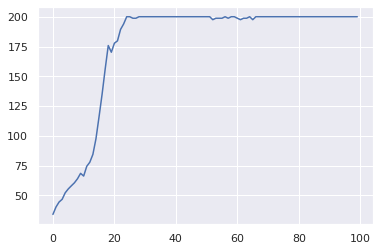

In [7]:
env = VectorizedEnvWrapper(gym.make("CartPole-v0"), num_envs=32)
agent = CategoricalPolicy(env, lr=1e-1)
agent = REINFORCE(env, agent)

For the next environment, we will be using `CartPoleSwingUp-v0`, which is *not* included in the basic `gym` installation. It can be installed with `pip install gym-cartpole-swingup`, and then imported to register the environment with `gym` (so we can create it via `gym.make`). 

This environment is very simple. It is like `CartPole-v0`, except the pole begins hanging down and must be swung into the upward position. The agent must learn to rapidly accelerate to add momentum to the pole, then switch directions to bring the pole above horizontal. This requires some level of exploration, so to improve our odds of randomly choosing good actions we massively scale up the number of parallel environments to 256. We also increase $\gamma = 0.999$ to account for the longer time horizon of this problem (capped at the length of the rollout, $T=1000$). With this many environments, we only need about 20 epochs to get a decent policy. We decrease the learning rate since we are using a larger network (2 hidden layers) and since the problem is harder and we don't want to make updates that overshoot the optimal policy.

In honesty, running this code with more environments, longer rollouts, more epochs and a smaller learning rate might be able to discover a really good policy that consistently performs well.

In [8]:
import gym_cartpole_swingup
env = VectorizedEnvWrapper(gym.make("CartPoleSwingUp-v0"), num_envs=256)

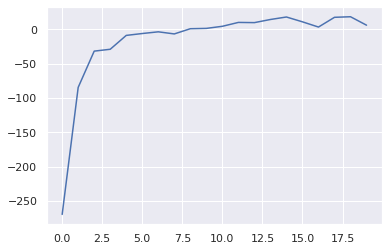

In [9]:
agent = DiagonalGaussianPolicy(env, lr=1e-2)
agent = REINFORCE(env, agent, gamma=0.999, epochs=20)

I hope that this thorough introduction to policy gradients has been helpful. In the next posts, we will diver deeper into actor-critic methods and more advanced policy gradient methods.